<a href="https://colab.research.google.com/github/AbdulBari8455/CNN-LSTM-RNN-with-Attention-Mechanisms-for-Image-Captioning-on-the-Flickr30k-Dataset/blob/main/CNN_LSTM_RNN_with_Attention_Mechanisms_for_Image_Captioning_on_the_Flickr30k_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow log messages to reduce console clutter.
import warnings
warnings.filterwarnings('ignore')  # Ignore Python warnings to simplify output logs.
import numpy as np  # Fundamental library for numerical computations in Python.
import matplotlib.pyplot as plt  # Visualization library for plotting graphs and data.
import random
from PIL import Image
from tensorflow.keras.models import Model, load_model  # For defining and loading deep learning models.
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, add, Bidirectional  # Essential layers for creating neural network architectures.
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization  # Layers for preprocessing and optimizing neural networks.
from tensorflow.keras.optimizers import Adam  # Popular optimizer for training deep learning models.
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau # Callbacks for controlling training processes.
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets.
from nltk.translate.bleu_score import corpus_bleu  # Evaluation metric for text generation (BLEU score).
from PIL import Image  # Image processing library for opening and manipulating images.
from tqdm import tqdm_notebook  # Progress bar for tracking loops, particularly in Jupyter notebooks.
from collections import Counter  # Useful for counting elements and generating frequency distributions.
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input  # Import the preprocessing function specific to the Resnet50 model to prepare input images
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm.notebook import tqdm  # Ensures compatibility with modern Jupyter environments
from tensorflow.keras.regularizers import l2
# Additional libraries
import pickle # for saving the Arrays
import pandas as pd  # Data manipulation and analysis library.
import seaborn as sns  # Statistical data visualization library.
import plotly.graph_objects as go  # For creating interactive visualizations and graphs.
import re  # Regular expressions for text preprocessing and manipulation.
import tensorflow as tf  # Core TensorFlow library for deep learning models.
from tensorflow.keras.applications.vgg16 import VGG16  # Pre-trained VGG16 model for image feature extraction.
from tensorflow.keras.preprocessing.image import img_to_array, load_img  # Functions to handle image preprocessing.
from tensorflow.keras.preprocessing.text import Tokenizer  # Tokenizes text for NLP tasks.
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Prepares sequences of text data for models.
from tensorflow.keras.utils import to_categorical, plot_model  # For one-hot encoding and visualizing model architectures.


# Impoting Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Define Images path
images_path_dir = '/content/drive/MyDrive/Project Dataset_fliker8k/Images/'

# Loading the Captions

In [4]:
def load_captions(file_path):
    with open(file_path, 'r') as file:
        captions_list = file.readlines()
        # Lowercasing the captions
        captions_list = [caption.lower() for caption in captions_list[1:]]
    return captions_list

def tokenize_captions(captions_list):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(captions_list)
    return tokenizer

# Loading the captions from the dataset
captions_file_path = "/content/drive/MyDrive/Project Dataset_fliker8k/captions.txt"  # Update this to the actual path of your captions file
captions_dataset = load_captions(captions_file_path)
captions_dataset[:9:3]


['1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set of stairs in an entry way .\n',
 '1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playhouse .\n',
 '1001773457_577c3a7d70.jpg,a black dog and a tri-colored dog playing with each other on the road .\n']

# Cleaning the Text

In [5]:
def clean_text(text):
    """
    Cleans the input text by removing punctuation, numbers, and extra whitespace.
    """
    # Removing punctuation marks
    text = re.sub(r'[^\w\s]', '', text)

    # Removing numbers
    text = re.sub(r'\d+', '', text)

    # Removing extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Cleaning the captions dataset
cleaned_captions_list = [clean_text(caption.split(',')[1]) for caption in captions_dataset]
cleaned_captions_list[:9:2]

['a child in a pink dress is climbing up a set of stairs in an entry way',
 'a little girl climbing into a wooden playhouse',
 'a little girl in a pink dress going into a wooden cabin',
 'a black dog and a tricolored dog playing with each other on the road',
 'two dogs of different breeds looking at each other on the road']

In [6]:
# Combine Image ID with cleaned captions
image_id_captions = []
for i in range(len(cleaned_captions_list)):
    # Adding 'start' and 'end' tokens to the captions
    formatted_caption = captions_dataset[i].split(',')[0] + '\t' + 'start ' + cleaned_captions_list[i] + ' end\n'
    image_id_captions.append(formatted_caption)

# Displaying a subset of the formatted image ID + caption pairs and the total count
image_id_captions[:20:3], len(image_id_captions)

(['1000268201_693b08cb0e.jpg\tstart a child in a pink dress is climbing up a set of stairs in an entry way end\n',
  '1000268201_693b08cb0e.jpg\tstart a little girl climbing the stairs to her playhouse end\n',
  '1001773457_577c3a7d70.jpg\tstart a black dog and a tricolored dog playing with each other on the road end\n',
  '1001773457_577c3a7d70.jpg\tstart two dogs on pavement moving toward each other end\n',
  '1002674143_1b742ab4b8.jpg\tstart a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it end\n',
  '1003163366_44323f5815.jpg\tstart a man lays on a bench while his dog sits by him end\n',
  '1003163366_44323f5815.jpg\tstart a shirtless man lies on a park bench with his dog end\n'],
 40455)

# Visualizing the Images with some Captions

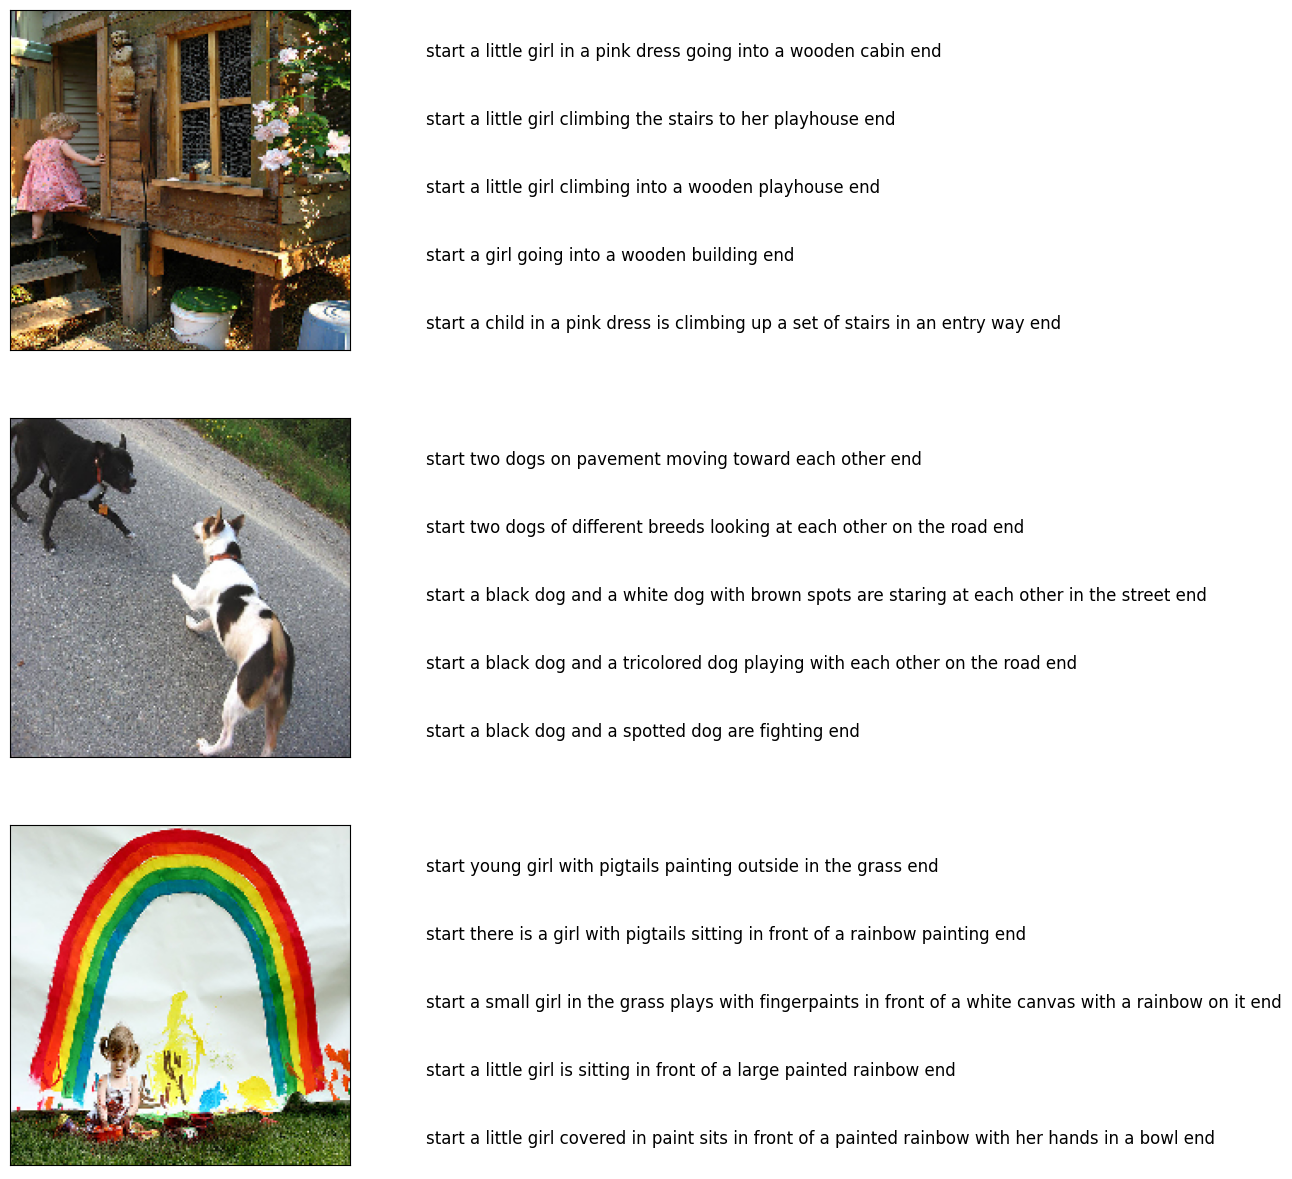

In [7]:
def visualize_image_captions(caption_data, num_images_to_display):
    """
    Visualize images along with their captions.

    Args:
    - caption_data (list): List containing image IDs and their captions (tab-separated).
    - num_images_to_display (int): Number of images to visualize.
    """
    # Initialize an empty dictionary to group captions by image ID
    image_captions_dict = {}
    # Iterate through the provided caption data
    for entry in caption_data:
        # Split the entry into image ID and caption based on the tab delimiter
        image_id, caption = entry.split('\t')
        # Check if the image ID is already in the dictionary
        if image_id not in image_captions_dict:
            # If not, create an empty list for this image ID
            image_captions_dict[image_id] = []
        # Append the caption to the list of captions for this image ID
        image_captions_dict[image_id].append(caption)
    # Select a subset of image IDs to display, ensuring they are distinct
    selected_image_ids = list(image_captions_dict.keys())[:num_images_to_display]
    # Initialize a counter for subplot positioning
    count = 1
    # Create a figure with a specified size for displaying images and captions
    fig = plt.figure(figsize=(10, 15))
    # Iterate through the selected image IDs
    for image_id in selected_image_ids:
        # Construct the path to the image file using the image directory and ID
        image_path = images_path_dir + image_id
        # Load the image from the file and resize it to (199, 199, 3)
        loaded_image = load_img(image_path, target_size=(199, 199, 3))
        # Add a subplot to the figure for displaying the image
        ax = fig.add_subplot(num_images_to_display, 2, count, xticks=[], yticks=[])
        # Display the loaded image in the subplot
        ax.imshow(loaded_image)
        # Increment the counter for the next subplot
        count += 1
        # Retrieve the captions associated with the current image ID
        captions = image_captions_dict[image_id]
        # Add another subplot for displaying the captions
        ax = fig.add_subplot(num_images_to_display, 2, count)
        # Disable axis display for the captions subplot
        plt.axis('off')
        # Prepare the subplot for text annotations
        ax.plot()
        # Set the x-axis limits to [0, 1] for caption placement
        ax.set_xlim(0, 1)
        # Set the y-axis limits to the number of captions for proper spacing
        ax.set_ylim(0, len(captions))
        # Iterate through each caption for the current image
        for i, caption in enumerate(captions):
            # Add the caption text to the subplot at the specified position
            ax.text(0, i, caption, fontsize=12)
        # Increment the counter for the next subplot
        count += 1
    # Display the entire figure with images and captions
    plt.show()

# Call the function to visualize the captions for 3 distinct images
visualize_image_captions(image_id_captions, 3)

# Distribution of Captions Length

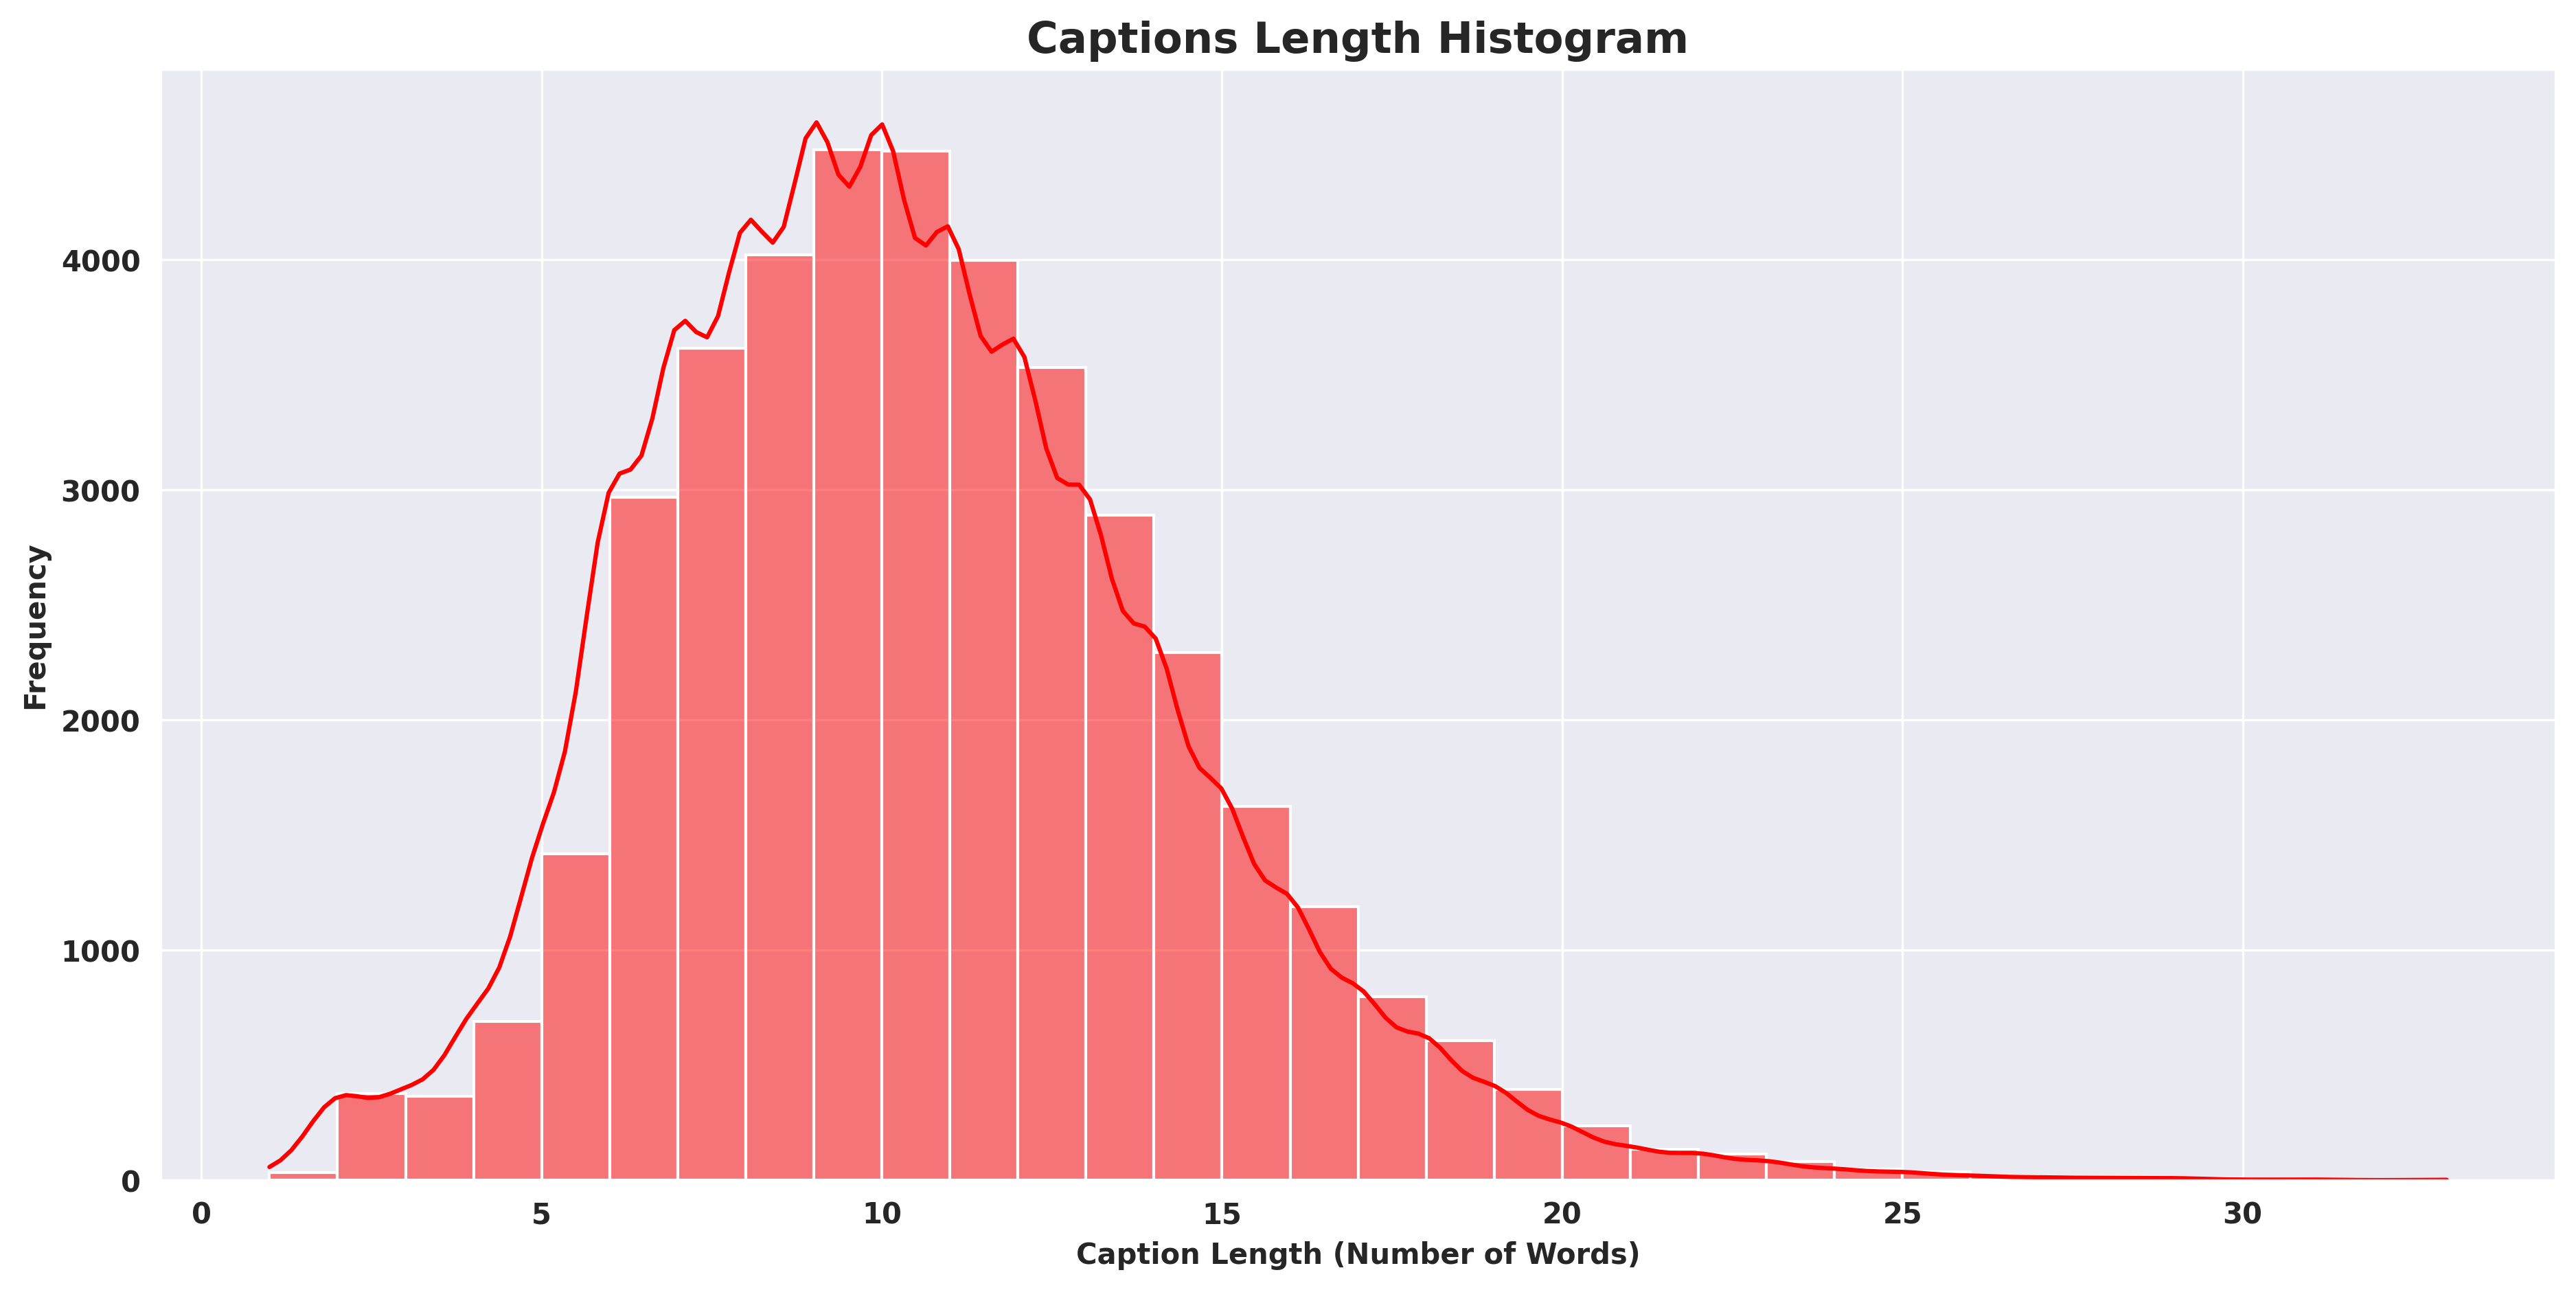

In [8]:
def plot_captions_length_distribution(captions_data):
    """
    Plot a histogram showing the distribution of caption lengths.

    Args:
    - captions_data (list): List of captions (strings).
    """
    # Create a figure with specified size and resolution
    plt.figure(figsize=(15, 7), dpi=300)
    # Set the style of the plot
    sns.set_style('darkgrid')
    # Plot the histogram of caption lengths
    sns.histplot(x=[len(caption.split(' ')) for caption in captions_data], kde=True, binwidth=1, color='red')
    # Add a title to the plot
    plt.title('Captions Length Histogram', fontsize=15, fontweight='bold')
    # Customize x-axis and y-axis ticks
    plt.xticks(fontweight='bold')
    plt.yticks(fontweight='bold')
    # Label the x-axis
    plt.xlabel('Caption Length (Number of Words)', fontweight='bold')
    # Label the y-axis
    plt.ylabel('Frequency', fontweight='bold')
    # Display the plot
    plt.show()

# Call the function to visualize the distribution of caption lengths
plot_captions_length_distribution(cleaned_captions_list)

# Tokenizing the Captions

In [9]:
# Tokenizing the captions and creating word-to-index mapping
tokenizer = tokenize_captions(cleaned_captions_list)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8586

# Spliting the Image ID's into Training, Validation, and Test Set

In [10]:
def split_image_ids(images_dir, test_size_val=0.15, test_size_test=0.1, random_seed=42):
    """
    Splits image IDs into training, validation, and testing sets.

    Args:
    - images_dir (str): Directory containing image files.
    - test_size_val (float): Fraction of images for validation set.
    - test_size_test (float): Fraction of validation images for test set.
    - random_seed (int): Random seed for reproducibility.

    Returns:
    - tuple: Lists of train, validation, and test image IDs.
    """
    # List all image IDs in the directory
    all_image_ids = os.listdir(images_dir)

    # Split image IDs into train and validation sets
    train_image_ids, val_image_ids = train_test_split(
        all_image_ids, test_size=test_size_val, random_state=random_seed
    )

    # Further split validation set into validation and test sets
    val_image_ids, test_image_ids = train_test_split(
        val_image_ids, test_size=test_size_test, random_state=random_seed
    )

    return train_image_ids, val_image_ids, test_image_ids, all_image_ids


def split_captions_by_ids(captions_data, train_ids, val_ids, test_ids):
    """
    Splits captions into training, validation, and test sets based on image IDs.

    Args:
    - captions_data (list): List of captions with image IDs (tab-separated).
    - train_ids (list): List of training image IDs.
    - val_ids (list): List of validation image IDs.
    - test_ids (list): List of testing image IDs.

    Returns:
    - tuple: Lists of training, validation, and testing captions.
    """
    # Initialize empty lists for captions
    train_captions, val_captions, test_captions = [], [], []

    # Iterate through the captions and split them based on image ID
    for caption in captions_data:
        image_id, _ = caption.split('\t')

        if image_id in train_ids:
            train_captions.append(caption)
        elif image_id in val_ids:
            val_captions.append(caption)
        elif image_id in test_ids:
            test_captions.append(caption)
        else:
            print('Unknown image ID!')

    return train_captions, val_captions, test_captions


# Directory containing images
images_directory = images_path_dir

# Split image IDs into train, validation, and test sets
train_ids, val_ids, test_ids, all_ids = split_image_ids(images_directory)

# Split captions into train, validation, and test sets
train_captions, val_captions, test_captions = split_captions_by_ids(
    image_id_captions, train_ids, val_ids, test_ids
)

# Display the first caption from each set and the number of images in each set
train_captions[0], val_captions[0], test_captions[0], len(train_captions) / 5, len(val_captions) / 5, len(test_captions) / 5


('1000268201_693b08cb0e.jpg\tstart a child in a pink dress is climbing up a set of stairs in an entry way end\n',
 '1007320043_627395c3d8.jpg\tstart a child playing on a rope net end\n',
 '1079274291_9aaf896cc1.jpg\tstart a little boy sticks his tongue out for the camera another boy looks on end\n',
 6877.0,
 1092.0,
 122.0)

# Extracting Features Using Resnet50

In [17]:
def preprocess_image_resnet50(image_path):
    """
    Preprocess an image for the ResNet50 model.

    Args:
    - image_path (str): Path to the image file.

    Returns:
    - np.ndarray: Preprocessed image ready for ResNet50 input.
    """
    # Load the image and resize to 299x299 (ResNet50 input size)
    img = load_img(image_path, target_size=(224, 224))
    # Convert the image to a numpy array
    img = img_to_array(img)
    # Add an additional dimension for batch size
    img = np.expand_dims(img, axis=0)
    # Preprocess the image for ResNet50
    img = preprocess_input(img)
    return img

def extract_image_features_resnet50(model, image_path):
    """
    Extract image features using the ResNet50 model.

    Args:
    - model (Model): Pre-trained ResNet50 model for feature extraction.
    - image_path (str): Path to the image file.

    Returns:
    - np.ndarray: Extracted features from the image.
    """
    # Preprocess the image
    img = preprocess_image_resnet50(image_path)
    # Extract features using the model
    features = model.predict(img, verbose=0)
    return features

# Load the pre-trained ResNet50 model
resnet50_model = ResNet50(weights='imagenet', input_shape=(224, 224, 3))
# Remove the final classification layer to use the model for feature extraction
resnet50_model.layers.pop()
# Create a new model that outputs features from the penultimate layer
resnet50_model = Model(inputs=resnet50_model.inputs, outputs=resnet50_model.layers[-2].output)

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Save the Features in Their Respective Variables

In [ ]:
# Dictionaries to store image features with their corresponding IDs for train, validation, and test sets
train_image_features, val_image_features, test_image_features = {}, {}, {}

# Progress bar to track the processing of image features
pbar = tqdm_notebook(total=len(all_ids), position=0, leave=True, colour='green')

# Iterate over all image IDs to extract and store features
for image_id in all_ids:
    # Construct the full path to the image file
    image_path = os.path.join(images_directory, image_id)

    # Extract features using the pre-trained VGG16 model
    image_features = extract_image_features_resnet50(resnet50_model, image_path)  # Using the resnet50_model feature extraction function

    # Check which dataset (train/val/test) the image belongs to and store its features
    if image_id in train_ids:
        # Store flattened features for training images
        train_image_features[image_id] = image_features.flatten()
        pbar.update(1)  # Update progress bar for processed training images

    elif image_id in val_ids:
        # Store flattened features for validation images
        val_image_features[image_id] = image_features.flatten()
        pbar.update(1)  # Update progress bar for processed validation images

    elif image_id in test_ids:
        # Store flattened features for test images
        test_image_features[image_id] = image_features.flatten()
        pbar.update(1)  # Update progress bar for processed test images

    else:
        # Print a warning if the image ID is not found in any dataset split
        print('Unknown image ID!')

# Close the progress bar once all images are processed
pbar.close()


  0%|          | 0/8091 [00:00<?, ?it/s]

# Saving Feature in pkl file to use later

In [ ]:
# Save the features to files
with open("train_image_features.pkl", "wb") as f:
    pickle.dump(train_image_features, f)

with open("val_image_features.pkl", "wb") as f:
    pickle.dump(val_image_features, f)

with open("test_image_features.pkl", "wb") as f:
    pickle.dump(test_image_features, f)

print("VGG16 features saved successfully!")

VGG16 features saved successfully!


In [12]:
# Load the features from files
with open("/content/train_image_features (1).pkl", "rb") as f:
    train_image_features = pickle.load(f)

with open("/content/val_image_features (1).pkl", "rb") as f:
    val_image_features = pickle.load(f)

with open("/content/test_image_features (1).pkl", "rb") as f:
    test_image_features = pickle.load(f)

print("Resnet50 features loaded successfully!")

Resnet50 features loaded successfully!


# Prepare Data For Training

In [13]:
def data_generator(captions, image_features, tokenizer, max_caption_length, batch_size):
    """
    Data generator to yield batches of training data for the image captioning model.

    Args:
    - captions (list): List of captions with their corresponding image IDs (tab-separated).
    - image_features (dict): Dictionary of precomputed image features keyed by image ID.
    - tokenizer (Tokenizer): Keras tokenizer to convert text captions to sequences.
    - max_caption_length (int): Maximum length of input captions (used for padding).
    - batch_size (int): Number of samples per batch.

    Yields:
    - tuple: ((X_images, X_captions), y), where:
        - X_images: Array of image feature vectors.
        - X_captions: Array of input sequences for captions.
        - y: Array of one-hot encoded target words.
    """
    num_samples = len(captions)  # Total number of captions
    image_ids = list(image_features.keys())  # List of all image IDs from the features dictionary

    while True:  # Infinite loop to generate data continuously for training
        np.random.shuffle(image_ids)  # Shuffle image IDs at the start of each epoch for randomness

        for start_idx in range(0, num_samples, batch_size):
            # Determine the end index of the current batch
            end_idx = min(start_idx + batch_size, num_samples)

            # Initialize empty lists to hold the batch data
            X_images, X_captions, y = [], [], []

            for caption in captions[start_idx:end_idx]:
                # Split the caption into image ID and text
                image_id, caption_text = caption.split('\t')
                caption_text = caption_text.rstrip('\n')  # Remove trailing newline characters

                # Convert the caption text into a sequence of integers using the tokenizer
                seq = tokenizer.texts_to_sequences([caption_text])[0]

                # Generate input-output pairs for each word in the sequence
                for i in range(1, len(seq)):
                    # Input sequence: All words up to the current word
                    in_seq = seq[:i]
                    # Output sequence: The current word
                    out_seq = seq[i]

                    # Pad the input sequence to the maximum caption length with right padding
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length, padding="post")[0]

                    # Convert the output word into a one-hot encoded vector
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # Append the input-output pairs to the batch lists
                    X_images.append(image_features[image_id])  # Corresponding image features
                    X_captions.append(in_seq)  # Input sequence for the caption
                    y.append(out_seq)  # One-hot encoded target word

            # Yield the batch data as NumPy arrays
            yield ((np.array(X_images), np.array(X_captions)), np.array(y))


In [14]:
def create_tf_dataset(generator_func, captions, image_features, tokenizer, max_caption_length, batch_size):
    """
    Converts a Python generator into a TensorFlow tf.data.Dataset for efficient data feeding.

    Args:
    - generator_func (function): The data generator function that yields batches of data.
    - captions (list): List of captions with their corresponding image IDs (tab-separated).
    - image_features (dict): Dictionary of precomputed image features keyed by image ID.
    - tokenizer (Tokenizer): Keras tokenizer to convert text captions to sequences.
    - max_caption_length (int): Maximum length of input captions (used for padding).
    - batch_size (int): Number of samples per batch.

    Returns:
    - tf.data.Dataset: A TensorFlow dataset object ready to be used for model training.
    """

    # Create a TensorFlow dataset from the generator function
    dataset = tf.data.Dataset.from_generator(
        # Use a lambda function to pass arguments to the generator function
        lambda: generator_func(captions, image_features, tokenizer, max_caption_length, batch_size),

        # Specify the output signature to define the shapes and data types of the generator's outputs
        output_signature=(
            (
                tf.TensorSpec(shape=(None, cnn_output_dim), dtype=tf.float32),  # X_images: CNN feature vectors
                tf.TensorSpec(shape=(None, max_caption_length), dtype=tf.int32),  # X_captions: Input caption sequences
            ),
            tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32),  # y: One-hot encoded target words
        )
    )

    return dataset


# Define Encoder Decoder Model for Training

In [15]:
def build_model(vocab_size, max_caption_length, cnn_output_dim):
    """
    Builds a simplified image captioning model with a single LSTM layer.

    Args:
    - vocab_size (int): Size of the vocabulary (number of unique words in the captions).
    - max_caption_length (int): Maximum length of input captions.
    - cnn_output_dim (int): Dimension of the feature vector output from the CNN.

    Returns:
    - model (Model): A compiled Keras model ready for training.
    """
    # --- CNN Encoder: Processes image features ---
    input_image = Input(shape=(cnn_output_dim,), name='Features_Input')
    fe1 = BatchNormalization()(input_image)
    fe2 = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(fe1)

    # --- RNN Decoder: Processes text sequences ---
    input_caption = Input(shape=(max_caption_length,), name='Sequence_Input')
    se1 = Embedding(vocab_size, 256, mask_zero=True)(input_caption)
    se1 = Dropout(0.2)(se1)
    se2 = LSTM(256, return_sequences=False, kernel_regularizer=l2(0.001))(se1)  # Single LSTM layer (no sequences)
    se2 = Dropout(0.2)(se2)

    # --- Combining Encoder and Decoder ---
    decoder1 = add([fe2, se2])  # Combine features and LSTM output
    decoder1 = BatchNormalization()(decoder1)
    decoder2 = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(decoder1)
    decoder2 = Dropout(0.2)(decoder2)
    outputs = Dense(vocab_size, activation='softmax', name='Output_Layer')(decoder2)

    # --- Create the Model ---
    model = Model(inputs=[input_image, input_caption], outputs=outputs, name='Simplified_Image_Captioning')
    return model

# Defining Model's Hyper Parameters

In [18]:
# Hyperparameters
max_caption_length = max(len(caption.split()) for caption in cleaned_captions_list) + 1
cnn_output_dim = resnet50_model.output_shape[1]  # Output size of resnet50_model penultimate layer
batch_size_train = 270
batch_size_val = 150

# Create Data Generators
train_tf_dataset = create_tf_dataset(
    data_generator, train_captions, train_image_features, tokenizer, max_caption_length, batch_size_train
)

val_tf_dataset = create_tf_dataset(
    data_generator, val_captions, val_image_features, tokenizer, max_caption_length, batch_size_val
)


In [19]:
# Debugging: Check dataset output
for batch in train_tf_dataset.take(1):
    print("Debugging shapes:")
    print("X_images shape:", batch[0][0].shape)  # Shape of X_images
    print("X_captions shape:", batch[0][1].shape)  # Shape of X_captions
    print("y shape:", batch[1].shape)  # Shape of y

Debugging shapes:
X_images shape: (3249, 2048)
X_captions shape: (3249, 34)
y shape: (3249, 8586)


# Compiling the Model

In [20]:
# Build the Image Captioning Model
caption_model = build_model(vocab_size, max_caption_length, cnn_output_dim)
# - Constructs the model with the provided vocabulary size, maximum caption length, and CNN output dimensions.

# Define the Adam Optimizer
optimizer = Adam(
    learning_rate=0.01,  # Initial learning rate for optimization
    clipnorm=1.0         # Gradient clipping to prevent exploding gradients
)

# Compile the Model
caption_model.compile(
    loss='categorical_crossentropy',  # Loss function for multi-class classification
    optimizer=optimizer              # Optimizer to adjust model weights
)

# Display the Model Summary
caption_model.summary()
# - Prints the structure of the model, including:
#   - Layer names, types, and output shapes
#   - Number of parameters per layer
#   - Total trainable and non-trainable parameters


Model: "Simplified_Image_Captioning"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Sequence_Input            │ (None, 34)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 34, 256)        │      2,198,016 │ Sequence_Input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Features_Input            │ (None, 2048)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 34, 256)        │              0 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 34)             │              0 │ Sequence_Input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 2048)           │          8,192 │ Features_Input[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 256)            │        525,312 │ dropout[0][0],         │
│                           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │        524,544 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 256)            │              0 │ dense[0][0],           │
│                           │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256)            │          1,024 │ add[0][0]              │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │         65,792 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 256)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Output_Layer (Dense)      │ (None, 8586)           │      2,206,602 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,529,482 (21.09 MB)

 Trainable params: 5,524,874 (21.08 MB)

 Non-trainable params: 4,608 (18.00 KB)

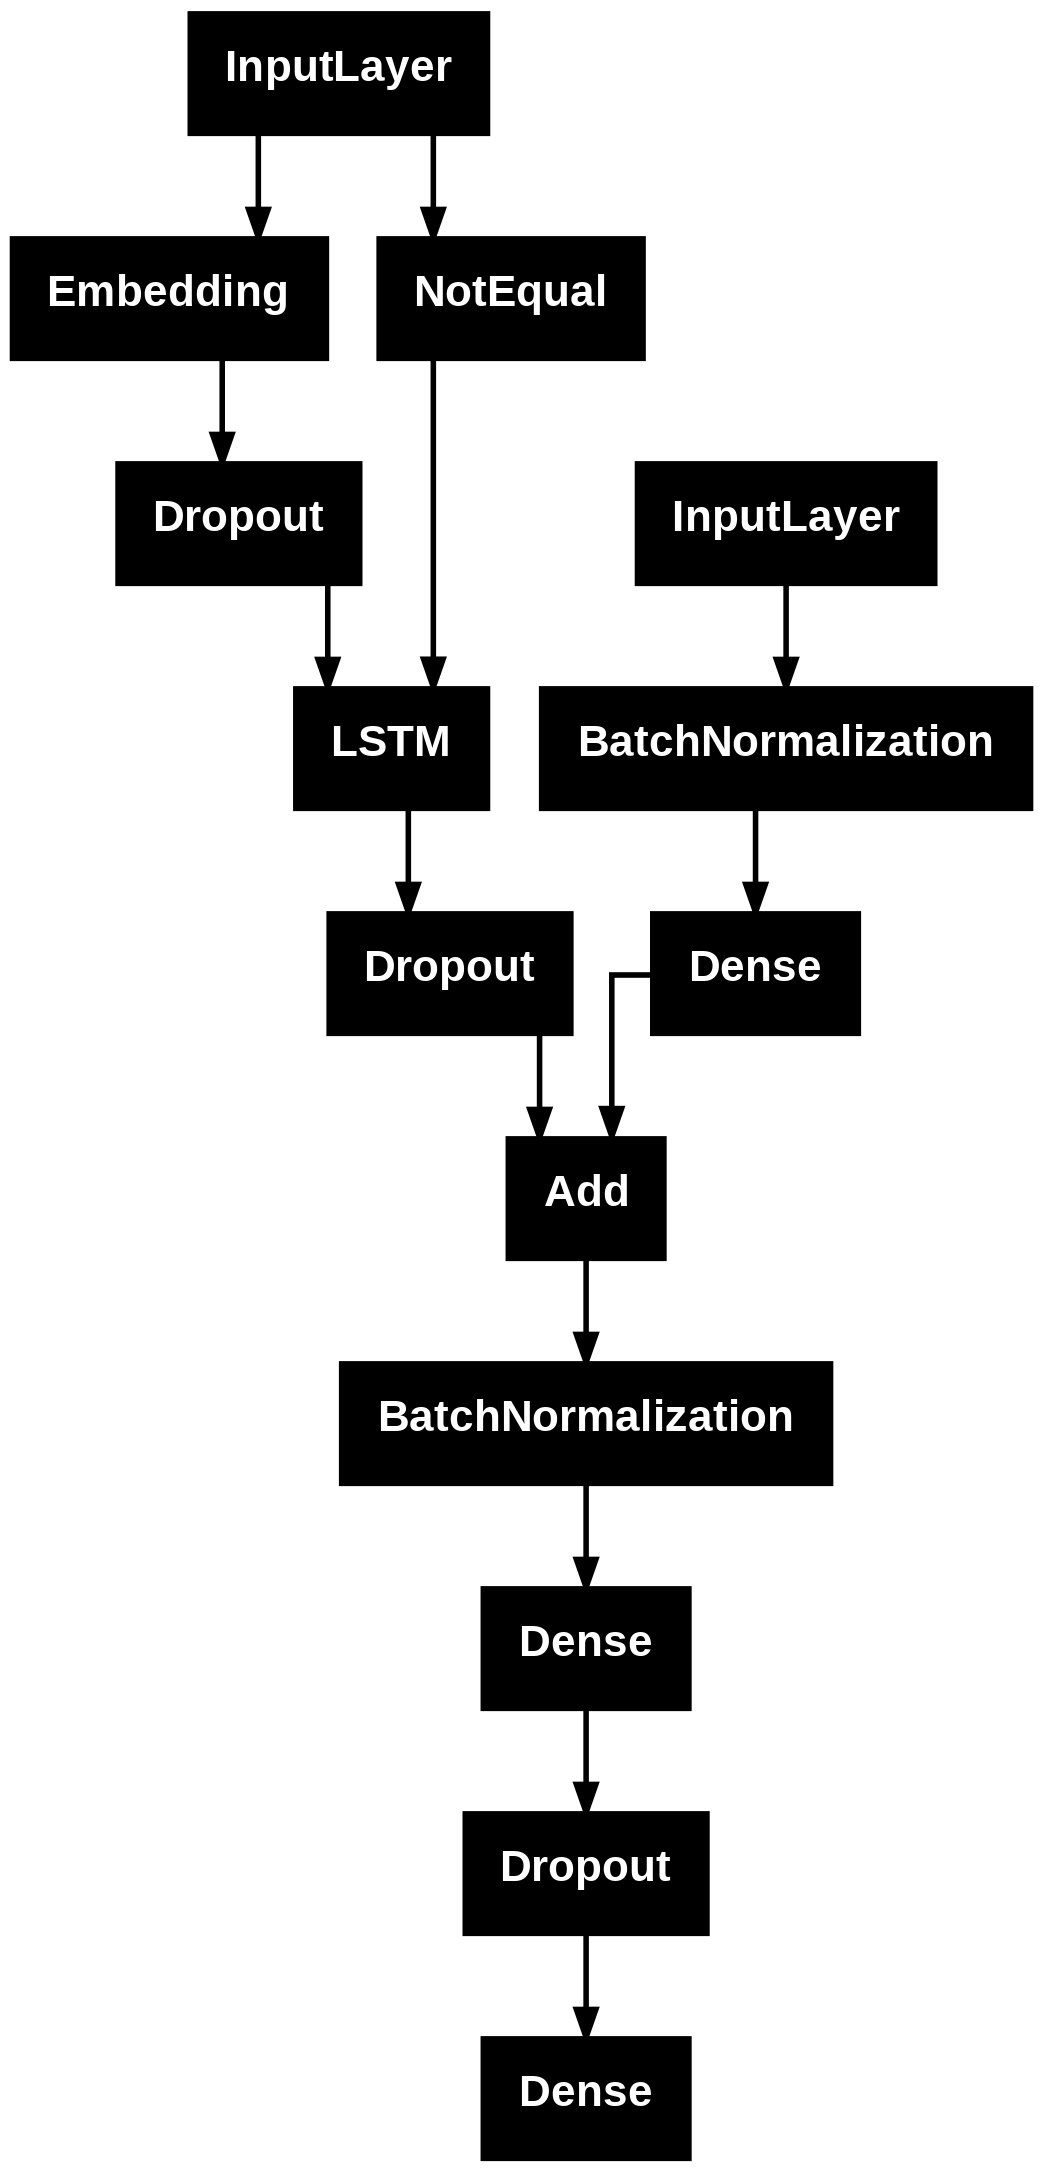

In [21]:
plot_model(caption_model)

# Training the Model

In [22]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Reduce learning rate on plateau
reduce_lr_on_plateau = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,  # Reduce learning rate by half
    patience=2,  # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6  # Minimum learning rate
)

# Training
history = caption_model.fit(
    train_tf_dataset,
    steps_per_epoch=len(train_captions) // batch_size_train,
    validation_data=val_tf_dataset,
    validation_steps=len(val_captions) // batch_size_val,
    epochs=50,
    callbacks=[early_stopping, reduce_lr_on_plateau]
)


Epoch 1/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 49s 337ms/step - loss: 6.2252 - val_loss: 5.4304 - learning_rate: 0.0100
Epoch 2/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 337ms/step - loss: 4.0781 - val_loss: 4.5639 - learning_rate: 0.0100
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 43s 340ms/step - loss: 3.7150 - val_loss: 3.9758 - learning_rate: 0.0100
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 44s 347ms/step - loss: 3.5167 - val_loss: 3.8155 - learning_rate: 0.0100
Epoch 5/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 40s 315ms/step - loss: 3.4019 - val_loss: 3.7414 - learning_rate: 0.0100
Epoch 6/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 39s 305ms/step - loss: 3.3039 - val_loss: 3.6854 - learning_rate: 0.0100
Epoch 7/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 46s 367ms/step - loss: 3.2347 - val_loss: 3.7092 - learning_rate: 0.0100
Epoch 8/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 327ms/step - loss: 3.1779 - val_loss: 3.7061 - learning_rate: 0.0100
Epoch 9/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 41s 329ms/step - loss: 3.0646 - val_loss: 3.3981 - learn

# Training Curves

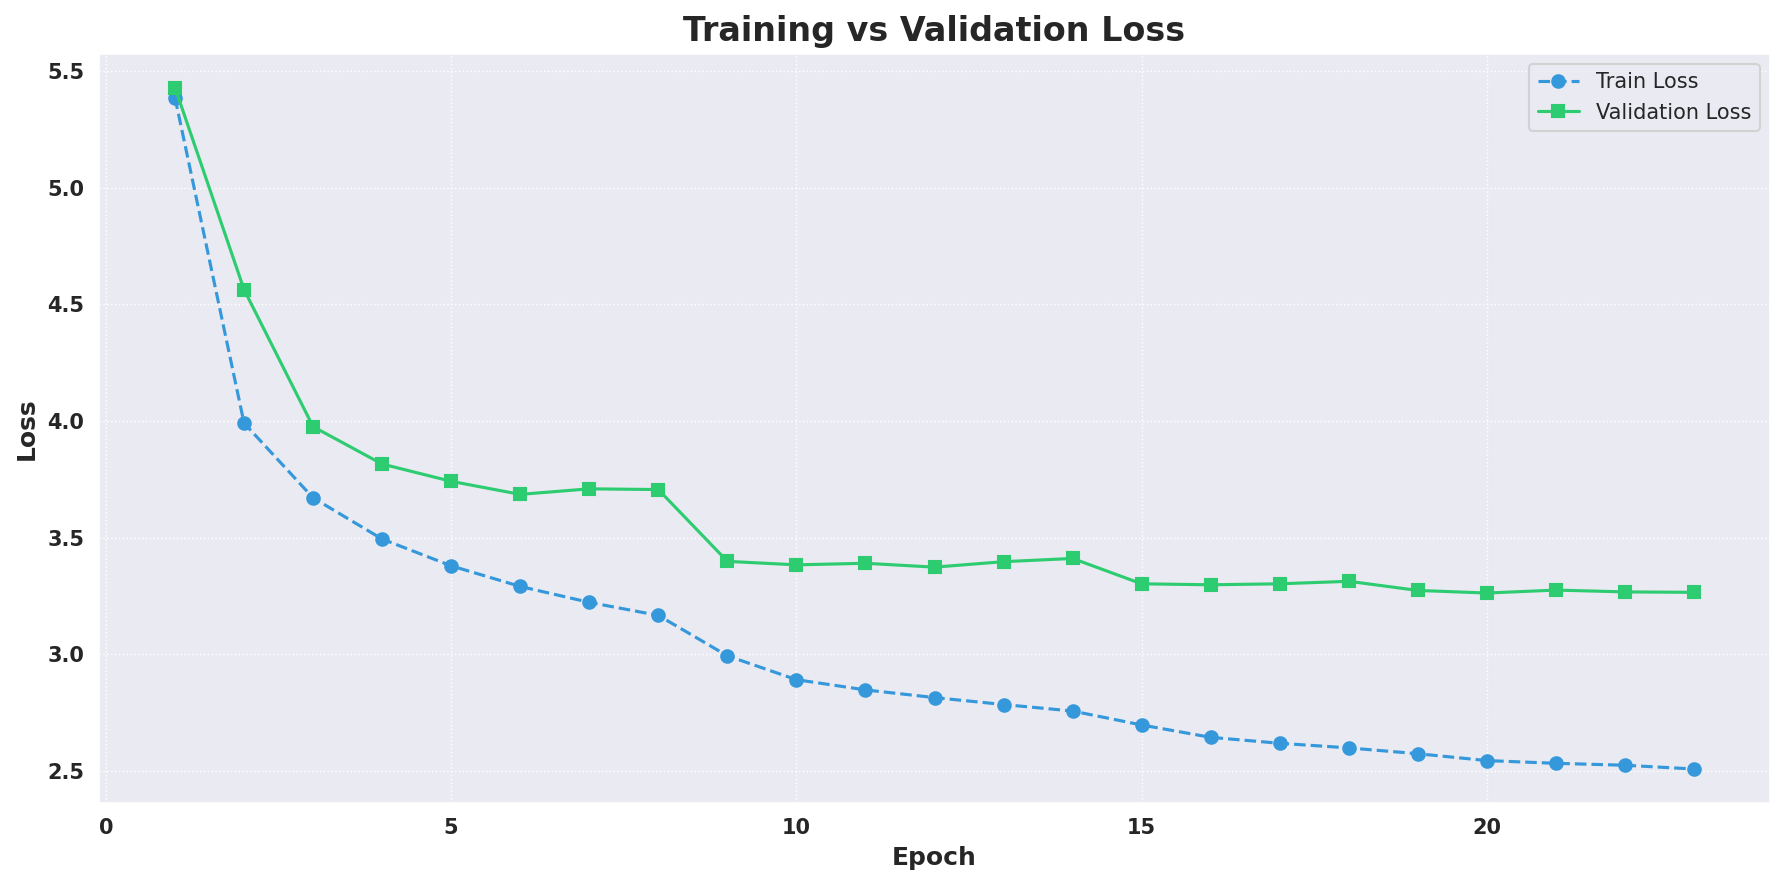

In [23]:
plt.figure(figsize=(12, 6), dpi=150)
sns.set_style('darkgrid')  # Change style to dark grid
plt.plot(
    [x + 1 for x in range(len(history.history['loss']))],
    history.history['loss'],
    linestyle='--',  # Dashed line for training loss
    marker='o',
    color='#3498DB',  # Soft blue for training loss
    label='Train Loss'
)
plt.plot(
    [x + 1 for x in range(len(history.history['val_loss']))],
    history.history['val_loss'],
    linestyle='-',  # Solid line for validation loss
    marker='s',
    color='#2ECC71',  # Soft green for validation loss
    label='Validation Loss'
)
plt.title('Training vs Validation Loss', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=12, fontweight='bold')
plt.ylabel('Loss', fontsize=12, fontweight='bold')
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.legend(loc='upper right', fontsize=10)
plt.grid(visible=True, linestyle=':', linewidth=0.7)  # Fine dotted grid
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


# Greedy Decoding Strategy Function

In [24]:
def greedy_generator(image_features):
    """
    Generates a caption for an image using a greedy decoding strategy.

    Args:
    - image_features (numpy array): The feature vector of the image.

    Returns:
    - str: The generated caption for the image.
    """
    in_text = 'start'

    for _ in range(max_caption_length):
        # Convert the current text into a sequence of integers
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # Pad the sequence to match the maximum caption length (right-padding)
        sequence = pad_sequences([sequence], maxlen=max_caption_length, padding="post")

        # Predict the next word using the model
        prediction = caption_model.predict([image_features.reshape(1, cnn_output_dim), sequence], verbose=0)

        # Get the index of the word with the highest probability
        idx = np.argmax(prediction)

        # Map the index to the corresponding word
        word = tokenizer.index_word.get(idx, None)
        if word is None:
            break  # Stop if the word index is invalid

        # Add the predicted word to the caption
        in_text += ' ' + word

        # Stop if the predicted word is the end token
        if word == 'end':
            break

    # Remove the start and end tokens from the final caption
    in_text = in_text.replace('start ', '').replace(' end', '')

    return in_text


# Beam Search Generator for Captions

In [25]:
def beam_search_generator(image_features, K_beams=3, log=False):
    start = [tokenizer.word_index['start']]
    start_word = [[start, 0.0]]

    for _ in range(max_caption_length):
        temp = []

        for s in start_word:
            # Prepare the sequence with right padding
            sequence = pad_sequences([s[0]], maxlen=max_caption_length, padding="post")

            # Predict next word probabilities
            preds = caption_model.predict([image_features.reshape(1, cnn_output_dim), sequence], verbose=0)
            word_preds = np.argsort(preds[0])[-K_beams:]

            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += np.log(preds[0][w]) if log else preds[0][w]
                temp.append([next_cap, prob])

        # Retain top K beams
        start_word = sorted(temp, reverse=False, key=lambda l: l[1])[-K_beams:]

    # Generate the best sequence
    final_seq = start_word[-1][0]
    caption = ' '.join(tokenizer.index_word[i] for i in final_seq if i != 0)
    caption = caption.replace('start ', '').replace(' end', '').strip()
    return caption


# Function to Find BLEU Score

In [26]:
def BLEU_score(actual, greedy, beam_search):
    """
    Calculates BLEU scores for greedy and beam search predictions.

    Args:
    - actual (list of list of str): List of reference captions (actual captions).
    - greedy (str): Caption generated by greedy decoding.
    - beam_search (str): Caption generated by beam search decoding.

    Returns:
    - dict: Dictionary containing BLEU scores and generated captions.
    """
    assert len(actual) > 0, "Actual captions cannot be empty."

    # Prepare hypotheses and references for corpus_bleu
    greedy_hypotheses = [greedy.split()]
    beam_hypotheses = [beam_search.split()]
    references = [actual]  # Corpus BLEU expects a list of lists

    # BLEU scores for greedy decoding
    score_greedy_1 = corpus_bleu(references, greedy_hypotheses, weights=(0.3, 0.3, 0.3, 0))
    score_greedy_2 = corpus_bleu(references, greedy_hypotheses, weights=(0.25, 0.25, 0.25, 0.25))

    # BLEU scores for beam search decoding
    score_BS_1 = corpus_bleu(references, beam_hypotheses, weights=(0.3, 0.3, 0.3, 0))
    score_BS_2 = corpus_bleu(references, beam_hypotheses, weights=(0.25, 0.25, 0.25, 0.25))

    return {
        "BLEU-1 Greedy": round(score_greedy_1, 5),
        "BLEU-2 Greedy": round(score_greedy_2, 5),
        "Greedy Caption": greedy,
        "BLEU-1 Beam Search": round(score_BS_1, 5),
        "BLEU-2 Beam Search": round(score_BS_2, 5),
        "Beam Search Caption": beam_search,
    }

# Actual Test Captions

In [27]:
# Group actual captions for each image ID in a dictionary
from collections import defaultdict

test_actual_captions = defaultdict(list)

for item in test_captions:
    image_id, caption = item.split('\t')
    test_actual_captions[image_id].append(caption.strip())  # Remove trailing newlines/whitespace


# Generate Captions for Test Set

In [28]:
# Dictionary to store generated captions
generated_captions = {}

# Progress bar for visual feedback
pbar = tqdm(total=len(test_image_features), desc="Generating Captions", position=0, leave=True, colour='green')

# Iterate over test image features and generate captions
for image_id, features in test_image_features.items():
    # Generate caption using the greedy generator
    generated_captions[image_id] = greedy_generator(features)

    # Update progress bar
    pbar.update(1)

# Close progress bar
pbar.close()

Generating Captions:   0%|          | 0/122 [00:00<?, ?it/s]

# Visualizing Random Images with Test set

In [29]:
# Random Visualization Function
def random_visualization(test_actual_captions, generated_captions, beam_search_fn, num_images=7):
    """
    Displays randomly selected images from the test set with their actual captions,
    greedy-predicted captions, beam search-predicted captions, and BLEU scores.

    Args:
    - test_actual_captions (dict): Dictionary of actual captions for test images.
    - generated_captions (function): Function to generate captions using the greedy decoder.
    - beam_search_fn (function): Function to generate captions using beam search.
    - num_images (int): Number of random images to display.
    """
    # Randomly select image IDs
    selected_image_ids = random.sample(list(test_actual_captions.keys()), num_images)

    # Set up the figure
    plt.figure(figsize=(15, num_images * 5))

    for idx, image_id in enumerate(selected_image_ids):
        # Load the image
        image_path = os.path.join(images_directory, image_id)
        img = Image.open(image_path)

        # Get actual captions
        actual_caps = test_actual_captions[image_id]
        actual_caps = [cap.replace("start ", "").replace(" end", "").strip() for cap in actual_caps]

        # Get greedy and beam search predictions
        greedy_cap = generated_captions(test_image_features[image_id])
        beam_cap = beam_search_fn(test_image_features[image_id])

        # Compute BLEU scores
        bleu_scores = BLEU_score(
            [cap.split() for cap in actual_caps],
            greedy_cap,
            beam_cap
        )

        # Plot the image
        ax = plt.subplot(num_images, 1, idx + 1)
        plt.imshow(img)
        plt.axis("off")

        # Prepare actual captions line by line
        actual_caps_text = "\n".join([f"- {cap}" for cap in actual_caps])

        # Set the title with captions and BLEU scores
        ax.set_title(
            f"Image ID: {image_id}\n"
            f"Actual Captions:\n{actual_caps_text}\n\n"
            f"Greedy Prediction: {greedy_cap} (BLEU-1: {bleu_scores['BLEU-1 Greedy']}, BLEU-2: {bleu_scores['BLEU-2 Greedy']})\n"
            f"Beam Search Prediction: {beam_cap} (BLEU-1: {bleu_scores['BLEU-1 Beam Search']}, BLEU-2: {bleu_scores['BLEU-2 Beam Search']})",
            fontsize=12
        )

    plt.tight_layout()
    plt.show()


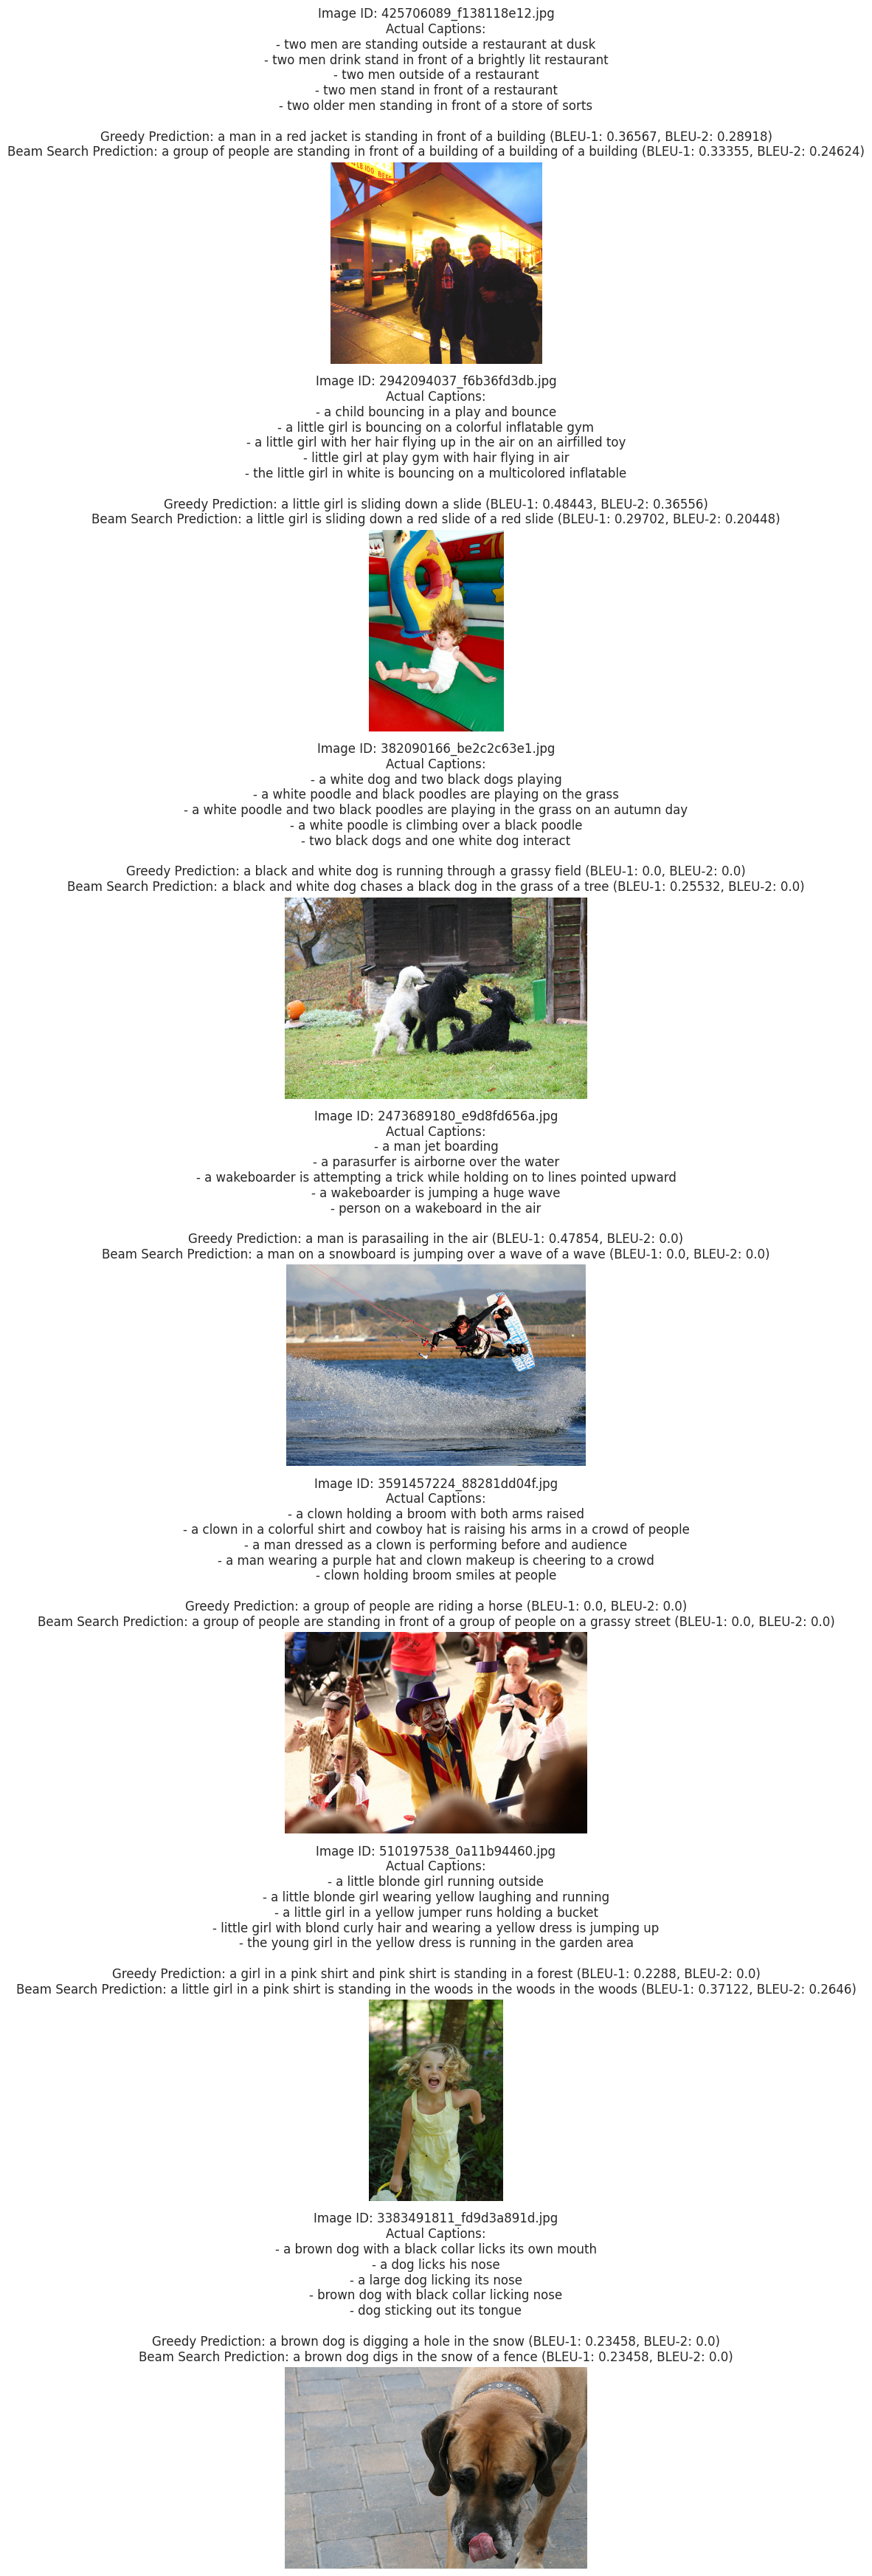

In [30]:
random_visualization(
    test_actual_captions=test_actual_captions,
    generated_captions=greedy_generator,
    beam_search_fn=beam_search_generator,
    num_images=7
)